<a href="https://colab.research.google.com/github/jokipatiaraja/TAAAAAA/blob/master/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
!nvidia-smi -L
%tensorflow_version 1.x
!pip install keras==2.2.5
!pip install tensorboardcolab
from tensorboardcolab import *
from PIL import Image, ImageDraw
from google.colab import drive
drive.mount('/content/gdrive')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-20a58fda-ebfd-775e-0b6b-6c08cba5b21d)
TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 2.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
os.chdir('/content')
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.75 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [3]:
os.chdir('/content')
cwd = os.getcwd()
print(cwd)
!git clone -b added_valuation_roi https://github.com/widianto21/orchid-dataset

/content
Cloning into 'orchid-dataset'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 426 (delta 49), reused 90 (delta 31), pack-reused 318
Receiving objects: 100% (426/426), 60.30 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [4]:
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")
assert os.path.exists(ROOT_DIR), "ROOT_DIR doesn't exist"

sys.path.append(ROOT_DIR)
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
print(ROOT_DIR)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/content/Mask_RCNN
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16059218993756475290
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18252143790997129425
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12674789791978527831
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7411219659370628077
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [5]:
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = "/content/drive/My Drive/Colab Notebooks/logs"

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
  utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [6]:
class CustomConfig(Config):
  NAME = "ORCHID"

  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

  NUM_CLASSES = 3 + 1
  IMAGE_MIN_DIM = 512
  IMAGE_MAX_DIM = 1024

  STEPS_PER_EPOCH = 160

  VALIDATION_STEPS = 10

  BACKBONE = 'resnet101'

  RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
  # TRAIN_ROIS_PER_IMAGE = 64
  # MAX_GT_INSTANCES = 50
  # POST_NMS_ROIS_INFERENCE = 500
  # POST_NMS_ROIS_TRAINING = 1000
  DETECTION_MIN_CONFIDENCE = 0.95
  # MINI_MASK_SHAPE = (128,128)
  # RPN_TRAIN_ANCHORS_PER_IMAGE = 64
  DETECTION_NMS_THRESHOLD = 0.1
  # WEIGHT_DECAY = 0.0001

config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [0]:
class CocoLikeDataset(utils.Dataset):
  def load_data(self, annotation_json, images_dir):
    json_file = open(annotation_json)
    coco_json = json.load(json_file)
    json_file.close()

    source_name = "coco_like"
    for category in coco_json['categories']:
      class_id = category['id']
      class_name = category['name']
      if class_id < 1 :
        print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
        return
      self.add_class(source_name, class_id, class_name)

    annotations = {}
    for annotation in coco_json['annotations'] : 
      image_id = int(annotation['image_id'])
      if image_id not in annotations:
        annotations[image_id] = []
        annotations[image_id].append(annotation)
    seen_images = {}
    for image in coco_json['images'] : 
      image_id = image['id']
      # print(image)
      if image_id in seen_images:
        print("Warning: skipping dupplicate image id : ". format(image))
      else:
        seen_images[image_id] = image
        try:
          image_file_name = image['file_name']
          image_width = image['width']
          image_height = image['height']
        except KeyError as key:
          print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
        image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
        image_annotations = annotations[image_id]

        self.add_image(
            source = source_name,
            image_id = image_id, 
            path = image_path,
            width = image_width,
            height = image_height,
            annotations=image_annotations
        )
  def load_mask(self, image_id):
    image_info = self.image_info[image_id]
    annotations = image_info['annotations']
    instance_masks = []
    class_ids = []

    for annotation in annotations:
      class_id = annotation['category_id']
      mask = Image.new('1', (image_info['width'], image_info['height']))
      mask_draw = ImageDraw.ImageDraw(mask, '1')
      # change code to accomodate single segmentation so remove the for loop
      segmentation = annotation['segmentation']
      mask_draw.polygon(segmentation, fill=1)
      bool_array = np.array(mask) > 0
      instance_masks.append(bool_array)
      class_ids.append(class_id)
    mask = np.dstack(instance_masks)
    class_ids = np.array(class_ids, dtype = np.int32)
    return mask, class_ids
  def check_missing(self):
    for image in self.image_info:
      for annotation in image['annotations']:
        # print(image)
        if annotation['category_id'] is None:
          break

In [0]:
dataset_train = CocoLikeDataset()

dataset_train.load_data(
    '/content/gdrive/My Drive/TA_DataSet/train1/via_export_coco (38).json', '/content/gdrive/My Drive/TA_DataSet/train1')

dataset_train.prepare()
dataset_train.check_missing()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/gdrive/My Drive/TA_DataSet/val1/via_export_coco (38).json', '/content/gdrive/My Drive/TA_DataSet/val1')
dataset_val.prepare()
dataset_val.check_missing()

In [9]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

model.load_weights(COCO_MODEL_PATH, by_name=True,
                exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                          "mrcnn_bbox", "mrcnn_mask"])








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








16


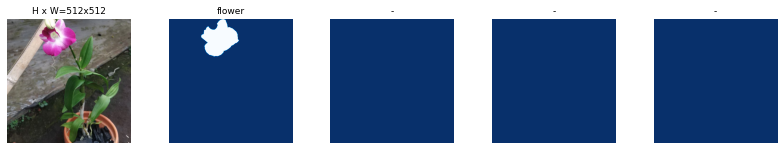

36


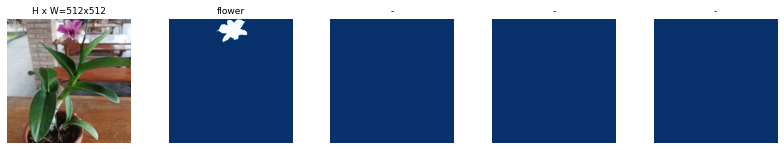

71


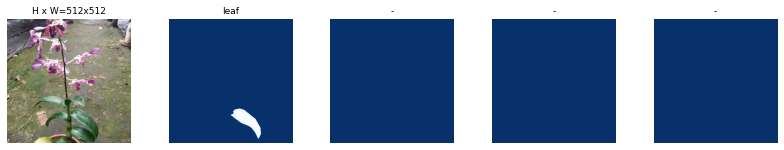

58


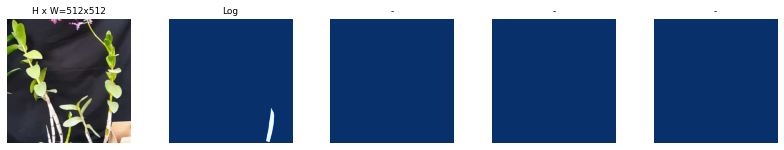

In [10]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [11]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=10, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
160/160 [==============================] - 73s 457ms/step - loss: 2.4317 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.2516 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.6209 - mrcnn_mask_loss: 0.4938 - val_loss: 2.1504 - val_rpn_class_loss: 0.0079 - val_rpn_bbox_loss: 1.2677 - val_mrcnn_class_loss: 0.0298 - val_mrcnn_bbox_loss: 0.4917 - val_mrcnn_mask_loss: 0.3534

Epoch 2/10
160/160 [==============================] - 49s 305ms/step - loss: 1.7336 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.8859 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.4838 - mrcnn_mask_loss: 0.3274 - val_loss: 3.9140 - val_rpn_class_loss: 0.0471 - val_rpn_bbox_loss: 3.1665 - val_mrcnn_class_loss: 0.0105 - val_mrcnn_bbox_loss: 0.4228 - val_mrcnn_mask_loss: 0.2670
Epoch 3/10
160/160 [==============================] - 49s 306ms/step - loss: 1.3735 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.7621 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.2411 - val_loss: 2.1354 - val_rp

In [12]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=20, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 10. LR=0.001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 11/20
160/160 [==============================] - 75s 466ms/step - loss: 0.5701 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.3004 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1115 - val_loss: 1.2508 - val_rpn_class_loss: 0.0038 - val_rpn_bbox_loss: 0.7420 - val_mrcnn_class_loss: 0.0263 - val_mrcnn_bbox_loss: 0.3180 - val_mrcnn_mask_loss: 0.1607
Epoch 12/20
160/160 [==============================] - 49s 307ms/step - loss: 0.6005 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.1165 - val_loss: 2.5088 - val_rpn_class_loss: 0.0243 - val_rpn_bbox_loss: 1.9811 - val_mrcnn_class_loss: 0.0289 - val_mrcnn_bbox_loss: 0.2923 - val_mrcnn_mask_loss: 0.1823
Epoch 13/20
160/160 [==============================] - 49s 306ms/step - loss: 0.5907 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.3145 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.1046 - val_loss: 2.3689 - val_rp

In [13]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=30, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 20. LR=0.001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 21/30
160/160 [==============================] - 75s 471ms/step - loss: 0.3362 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.0856 - val_loss: 0.9372 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.5431 - val_mrcnn_class_loss: 0.0114 - val_mrcnn_bbox_loss: 0.2210 - val_mrcnn_mask_loss: 0.1601
Epoch 22/30
160/160 [==============================] - 49s 307ms/step - loss: 0.2640 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.0808 - val_loss: 1.9808 - val_rpn_class_loss: 0.0129 - val_rpn_bbox_loss: 1.5791 - val_mrcnn_class_loss: 0.0155 - val_mrcnn_bbox_loss: 0.1983 - val_mrcnn_mask_loss: 0.1750
Epoch 23/30
160/160 [==============================] - 49s 306ms/step - loss: 0.2206 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0735 - val_loss: 1.6123 - val_rp

In [14]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=40, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 30. LR=0.001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 31/40
160/160 [==============================] - 74s 464ms/step - loss: 0.1913 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0699 - val_loss: 0.7257 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.3780 - val_mrcnn_class_loss: 0.0139 - val_mrcnn_bbox_loss: 0.1937 - val_mrcnn_mask_loss: 0.1380
Epoch 32/40
160/160 [==============================] - 48s 299ms/step - loss: 0.2867 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0805 - val_loss: 1.8686 - val_rpn_class_loss: 0.0141 - val_rpn_bbox_loss: 1.3648 - val_mrcnn_class_loss: 0.0450 - val_mrcnn_bbox_loss: 0.2520 - val_mrcnn_mask_loss: 0.1927
Epoch 33/40
160/160 [==============================] - 48s 300ms/step - loss: 0.2623 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.0665 - val_loss: 1.3443 - val_rp

In [15]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=50, 
            layers='4+')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 40. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c        

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 41/50
160/160 [==============================] - 110s 689ms/step - loss: 0.2446 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1295 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0603 - val_loss: 1.0694 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.7171 - val_mrcnn_class_loss: 0.0166 - val_mrcnn_bbox_loss: 0.1874 - val_mrcnn_mask_loss: 0.1466
Epoch 42/50
160/160 [==============================] - 72s 448ms/step - loss: 0.1539 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0596 - val_loss: 2.0877 - val_rpn_class_loss: 0.0151 - val_rpn_bbox_loss: 1.6164 - val_mrcnn_class_loss: 0.0252 - val_mrcnn_bbox_loss: 0.2129 - val_mrcnn_mask_loss: 0.2181
Epoch 43/50
160/160 [==============================] - 71s 447ms/step - loss: 0.1251 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0555 - val_loss: 1.4491 - val_r

In [16]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=60, 
            layers='4+')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 50. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c        

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 51/60
160/160 [==============================] - 113s 707ms/step - loss: 0.1085 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0542 - val_loss: 1.0935 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.7524 - val_mrcnn_class_loss: 0.0097 - val_mrcnn_bbox_loss: 0.1776 - val_mrcnn_mask_loss: 0.1523
Epoch 52/60
160/160 [==============================] - 72s 453ms/step - loss: 0.1112 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0127 - mrcnn_mask_loss: 0.0559 - val_loss: 1.8137 - val_rpn_class_loss: 0.0160 - val_rpn_bbox_loss: 1.4043 - val_mrcnn_class_loss: 0.0218 - val_mrcnn_bbox_loss: 0.1325 - val_mrcnn_mask_loss: 0.2391
Epoch 53/60
160/160 [==============================] - 72s 452ms/step - loss: 0.1026 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.0529 - val_loss: 1.6384 - val_r

In [17]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=70, 
            layers='4+')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 60. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c        

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 61/70
160/160 [==============================] - 111s 694ms/step - loss: 0.0924 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0108 - mrcnn_mask_loss: 0.0527 - val_loss: 0.8640 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.5696 - val_mrcnn_class_loss: 0.0118 - val_mrcnn_bbox_loss: 0.1475 - val_mrcnn_mask_loss: 0.1335
Epoch 62/70
160/160 [==============================] - 71s 447ms/step - loss: 0.0828 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0108 - mrcnn_mask_loss: 0.0530 - val_loss: 2.1365 - val_rpn_class_loss: 0.0171 - val_rpn_bbox_loss: 1.4523 - val_mrcnn_class_loss: 0.0284 - val_mrcnn_bbox_loss: 0.1920 - val_mrcnn_mask_loss: 0.4467
Epoch 63/70
160/160 [==============================] - 71s 446ms/step - loss: 0.0849 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0100 - mrcnn_mask_loss: 0.0496 - val_loss: 1.3203 - val_r

In [18]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=80, 
            layers='4+')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 70. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c        

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 71/80
160/160 [==============================] - 113s 703ms/step - loss: 0.0777 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.0489 - val_loss: 0.9663 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.6700 - val_mrcnn_class_loss: 0.0160 - val_mrcnn_bbox_loss: 0.1486 - val_mrcnn_mask_loss: 0.1301
Epoch 72/80
160/160 [==============================] - 72s 447ms/step - loss: 0.0846 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0082 - mrcnn_mask_loss: 0.0510 - val_loss: 1.8003 - val_rpn_class_loss: 0.0168 - val_rpn_bbox_loss: 1.4123 - val_mrcnn_class_loss: 0.0425 - val_mrcnn_bbox_loss: 0.1093 - val_mrcnn_mask_loss: 0.2193
Epoch 73/80
160/160 [==============================] - 72s 447ms/step - loss: 0.0848 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0085 - mrcnn_mask_loss: 0.0484 - val_loss: 1.4197 - val_r

In [19]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=90, 
            layers='4+')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 80. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c        

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 81/90
160/160 [==============================] - 113s 706ms/step - loss: 0.0787 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0088 - mrcnn_mask_loss: 0.0482 - val_loss: 0.9052 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.6330 - val_mrcnn_class_loss: 0.0086 - val_mrcnn_bbox_loss: 0.1309 - val_mrcnn_mask_loss: 0.1313
Epoch 82/90
160/160 [==============================] - 72s 450ms/step - loss: 0.0781 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0492 - val_loss: 1.7473 - val_rpn_class_loss: 0.0157 - val_rpn_bbox_loss: 1.3666 - val_mrcnn_class_loss: 0.0289 - val_mrcnn_bbox_loss: 0.0948 - val_mrcnn_mask_loss: 0.2413
Epoch 83/90
160/160 [==============================] - 72s 448ms/step - loss: 0.0772 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0070 - mrcnn_mask_loss: 0.0472 - val_loss: 1.3707 - val_r

In [20]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=100, 
            layers='4+')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 90. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c        

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 91/100
160/160 [==============================] - 114s 715ms/step - loss: 0.0698 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0475 - val_loss: 0.7403 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.4753 - val_mrcnn_class_loss: 0.0223 - val_mrcnn_bbox_loss: 0.1100 - val_mrcnn_mask_loss: 0.1312
Epoch 92/100
160/160 [==============================] - 72s 450ms/step - loss: 0.0675 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0077 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0477 - val_loss: 1.5797 - val_rpn_class_loss: 0.0150 - val_rpn_bbox_loss: 1.0845 - val_mrcnn_class_loss: 0.0313 - val_mrcnn_bbox_loss: 0.1442 - val_mrcnn_mask_loss: 0.3046
Epoch 93/100
160/160 [==============================] - 72s 450ms/step - loss: 0.0590 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.0448 - val_loss: 1.2340 - va

In [21]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/100, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=110, 
            layers='all')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 100. LR=1e-05

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 101/110
160/160 [==============================] - 132s 822ms/step - loss: 0.0574 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.0449 - val_loss: 0.8447 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.5608 - val_mrcnn_class_loss: 0.0243 - val_mrcnn_bbox_loss: 0.1208 - val_mrcnn_mask_loss: 0.1372
Epoch 102/110
160/160 [==============================] - 83s 521ms/step - loss: 0.0545 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0020 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.0450 - val_loss: 1.7272 - val_rpn_class_loss: 0.0155 - val_rpn_bbox_loss: 1.2468 - val_mrcnn_class_loss: 0.0298 - val_mrcnn_bbox_loss: 0.1220 - val_mrcnn_mask_loss: 0.3131
Epoch 103/110
160/160 [==============================] - 83s 521ms/step - loss: 0.0528 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0015 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.0431 - val_loss: 1.2920 -

In [22]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/100, 
            # custom_callbacks=[TensorBoardColabCallback(tbc)],
            epochs=120, 
            layers='all')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 110. LR=1e-05

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 111/120
160/160 [==============================] - 133s 828ms/step - loss: 0.0506 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 6.5269e-04 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0433 - val_loss: 0.8243 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.5501 - val_mrcnn_class_loss: 0.0162 - val_mrcnn_bbox_loss: 0.1179 - val_mrcnn_mask_loss: 0.1386
Epoch 112/120
160/160 [==============================] - 84s 522ms/step - loss: 0.0510 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 6.4506e-04 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0439 - val_loss: 1.6656 - val_rpn_class_loss: 0.0153 - val_rpn_bbox_loss: 1.2651 - val_mrcnn_class_loss: 0.0279 - val_mrcnn_bbox_loss: 0.0955 - val_mrcnn_mask_loss: 0.2619
Epoch 113/120
160/160 [==============================] - 83s 521ms/step - loss: 0.0489 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 6.1057e-04 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0419 - val_lo

In [23]:
class TestingConfig(Config):
  NAME = "ORCHID"

  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

  NUM_CLASSES = 3 + 1
  IMAGE_MIN_DIM = 512
  IMAGE_MAX_DIM = 1408

  STEPS_PER_EPOCH = 480

  VALIDATION_STEPS = 50

  BACKBONE = 'resnet101'

  # RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)
  RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
  # RPN_ANCHOR_SCALES = (16, 32, 64, 128, 512)
  # TRAIN_ROIS_PER_IMAGE = 32
  # MAX_GT_INSTANCES = 100
  POST_NMS_ROIS_INFERENCE = 500
  POST_NMS_ROIS_TRAINING = 1000
  DETECTION_MIN_CONFIDENCE = 0.90
  # MINI_MASK_SHAPE = (128,128)
  # RPN_TRAIN_ANCHORS_PER_IMAGE = 128
  # DETECTION_NMS_THRESHOLD = 0.0

testconfig = TestingConfig()
testconfig.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1408
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1408 1408    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [24]:
model_inference = modellib.MaskRCNN(mode="inference", 
                          config=testconfig,
                          model_dir=MODEL_DIR)

# model_path = model.find_last()
model_path = "/content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_0120.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model_inference.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/My Drive/Colab Notebooks/logs/orchid20200507T0258/mask_rcnn_orchid_0120.h5
Re-starting from epoch 120


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1408, 1408, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 495132, 4)        min:   -0.06433  max:    1.01884  float32


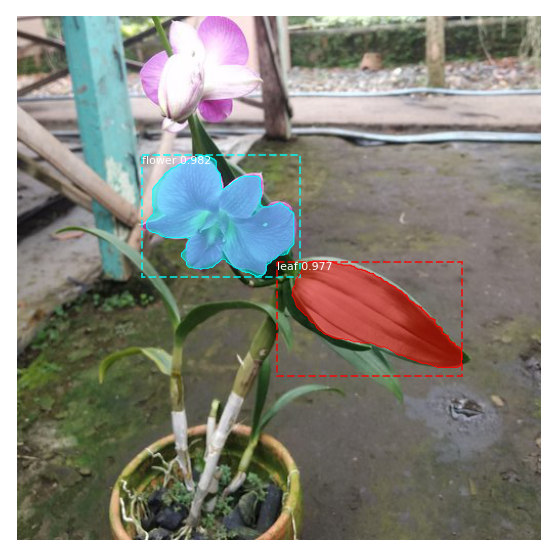

[1 2]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1408, 1408, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 495132, 4)        min:   -0.06433  max:    1.01884  float32


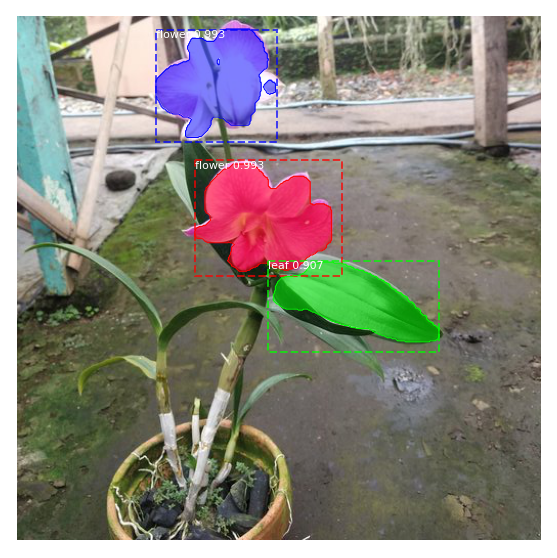

[1 1 2]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1408, 1408, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 495132, 4)        min:   -0.06433  max:    1.01884  float32


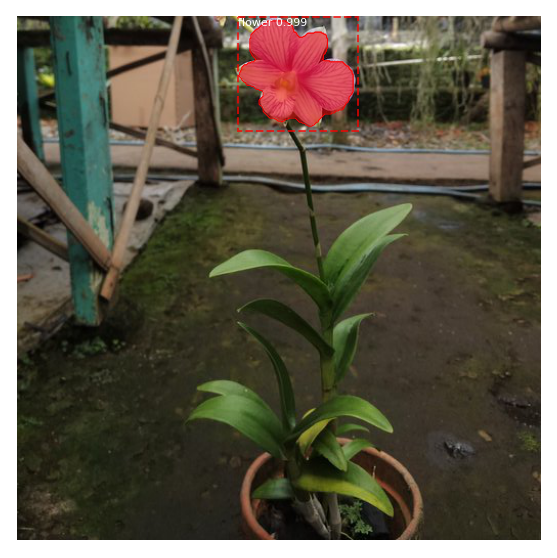

[1]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1408, 1408, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 495132, 4)        min:   -0.06433  max:    1.01884  float32


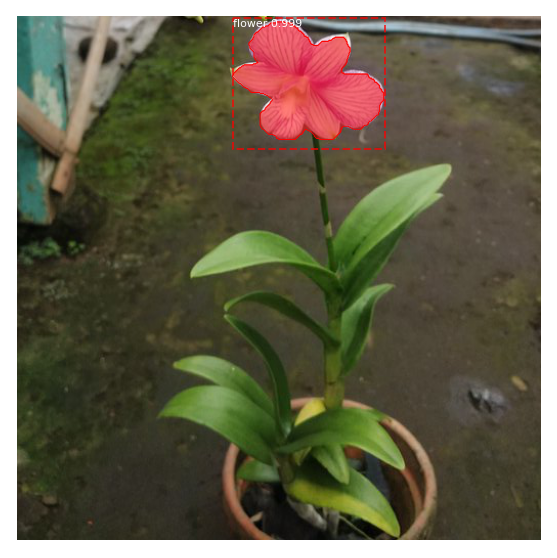

[1]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1408, 1408, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 495132, 4)        min:   -0.06433  max:    1.01884  float32


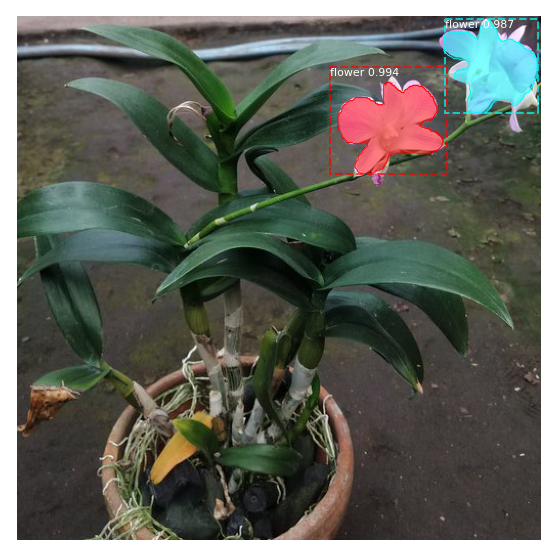

[1 1]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1408, 1408, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 495132, 4)        min:   -0.06433  max:    1.01884  float32


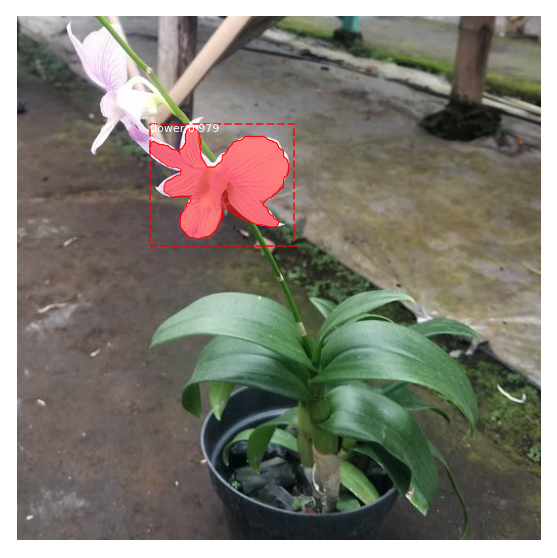

[1]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1408, 1408, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 495132, 4)        min:   -0.06433  max:    1.01884  float32


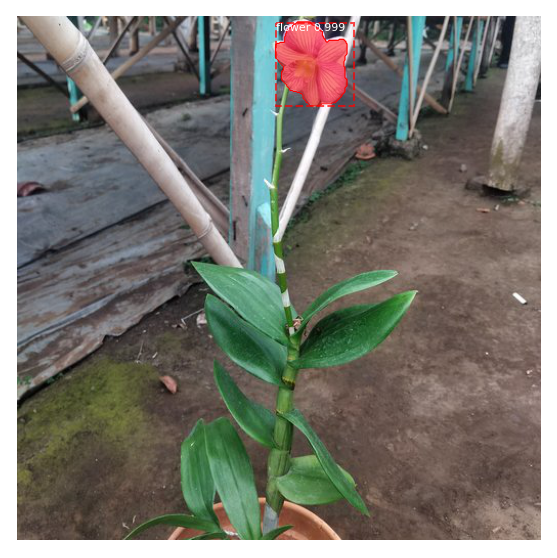

[1]


In [27]:
import skimage

test_list=[
  '/content/gdrive/My Drive/TA_DataSet/test1/rsz_012.jpg',
  '/content/gdrive/My Drive/TA_DataSet/test1/rsz_1162.jpg',
  '/content/gdrive/My Drive/TA_DataSet/test1/rsz_160.jpg',
  '/content/gdrive/My Drive/TA_DataSet/test1/rsz_241.jpg',
  '/content/gdrive/My Drive/TA_DataSet/test1/rsz_140.jpg',
  '/content/gdrive/My Drive/TA_DataSet/test1/rsz_254.jpg',
  '/content/gdrive/My Drive/TA_DataSet/test1/rsz_420.jpg'
]



for image in test_list:
  img = skimage.io.imread(image)
  img_arr = np.array(img)
  results = model_inference.detect([img_arr], verbose=1)
  r = results[0]
  visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                              dataset_val.class_names, r['scores'], figsize=(10,10))
  print(r['class_ids'])